# MNIST Deep Autoencoder

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

## Prepare dataset

In [2]:
def map_image(image, label):
  image = tf.cast(image, dtype=tf.float32)
  image /= 255.0
  image = tf.reshape(image, shape=(784,))
  return image, image

In [3]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1024

train_dataset = tfds.load('mnist', as_supervised=True, split='train')
train_dataset = train_dataset.map(map_image)
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).repeat()

test_dataset = tfds.load('mnist', as_supervised=True, split='test')
test_dataset = test_dataset.map(map_image)
test_dataset = test_dataset.batch(BATCH_SIZE).repeat()

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Build the model

In [4]:
def deep_autoencoder(inputs):
  encoder = tf.keras.layers.Dense(128, activation='relu')(inputs)
  encoder = tf.keras.layers.Dense(64, activation='relu')(encoder)
  encoder = tf.keras.layers.Dense(32, activation='relu')(encoder)

  decoder = tf.keras.layers.Dense(64, activation='relu')(encoder)
  decoder = tf.keras.layers.Dense(128, activation='relu')(decoder)
  decoder = tf.keras.layers.Dense(784, activation='sigmoid')(decoder)
  return encoder, decoder

inputs = tf.keras.layers.Input(shape=(784,))
deep_encoder_output, deep_decoder_output = deep_autoencoder(inputs)

deep_encoder_model = tf.keras.Model(inputs=inputs, outputs=deep_encoder_output)

deep_autoencoder_model = tf.keras.Model(inputs=inputs, outputs=deep_decoder_output)
deep_autoencoder_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 784)]             0         
_________________________________________________________________
dense (Dense)                (None, 128)               100480    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 64)                2112      
_________________________________________________________________
dense_4 (Dense)              (None, 128)               8320      
_________________________________________________________________
dense_5 (Dense)              (None, 784)               1011

In [5]:
deep_autoencoder_model.compile(optimizer=tf.keras.optimizers.Adam(), 
                          loss='binary_crossentropy')

## Train the model

In [6]:
train_steps = 60000 // BATCH_SIZE
history = deep_autoencoder_model.fit(train_dataset, steps_per_epoch=train_steps, epochs=50, verbose=False)

## Display results

In [7]:
def display_one_row(disp_images, offset, shape=(28, 28)):
  '''Display sample outputs in one row.'''
  for idx, test_image in enumerate(disp_images):
    plt.subplot(3, 10, offset + idx + 1)
    plt.xticks([])
    plt.yticks([])
    test_image = np.reshape(test_image, shape)
    plt.imshow(test_image, cmap='gray')

def display_results(disp_input_images, disp_encoded, disp_predicted, enc_shape=(8,4)):
  '''Displays the input, encoded, and decoded output values.'''
  plt.figure(figsize=(15, 5))
  display_one_row(disp_input_images, 0, shape=(28,28,))
  display_one_row(disp_encoded, 10, shape=enc_shape)
  display_one_row(disp_predicted, 20, shape=(28,28,))

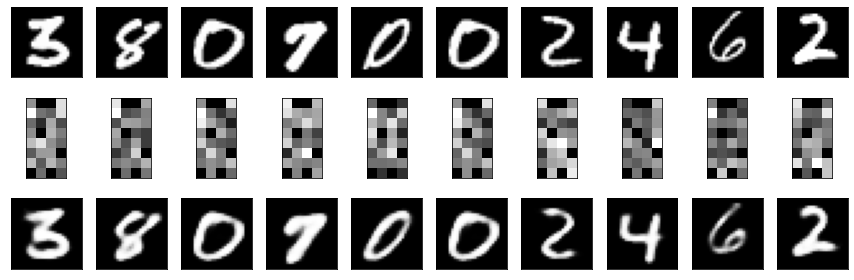

In [8]:
test_data = test_dataset.take(1)

output_samples = []
for input_image, image in tfds.as_numpy(test_data):
  output_samples = input_image

idxs = np.random.choice(BATCH_SIZE, size=10)
encoded_predicted = deep_encoder_model.predict(test_data)
autoencoder_predicted = deep_autoencoder_model.predict(test_data)

display_results(output_samples[idxs], encoded_predicted[idxs], autoencoder_predicted[idxs])